# Wang Landau Algorithm


The algorithm is very useful for studing the phase transition
phenomena because it does not suffer from the critical slowing down
and gives direct access to thermodynamic potential and its derivatives

\newslide

Consider the 4-site Ising model.
<img src="figs/wnlan.xfig.pdf" width="80%">

Many energy levels are highly degenerate.

In case of periodic boundary conditions, the allowed energy levels of
the ising model are: $-2J N$, $-2J (N-4)$, $-2J(N-6)$,$-2J(N-8)$
... $2J N$. The number of
energy levels is of the order of $N$ while the number of all possible
states is $2^N$. Therefore many states have to be heavily
degenerate. In Markov-chain simulation at certain low temperature $T$, most of
states visited have the same energy close to $\langle E \rangle$ ( the
probability for a state is $e^{-E/T}$).

The classical MC simulation generates canonical distribution at a
given temperature $P(E) \propto g(E)e^{-E/T}$. The idea of Wang-Landau is
to estimate the many-body density of states $g(E)$ directly. The
temperature is not required for the simulation and by analyzing $g(E)$
one can study thermodynamics at \textit{any} temperature.

If the density of state $g(E)$ is known, the free energy is simply given by 
\begin{equation}
  F(T) = -k_B T \log (Z) = -k_B T
  \log{\sum_E g(E) e^{-E/T}}
\end{equation}

In the Wang-Landau algorithm the random walk in energy space is
performed and the probability to visit a state with energy $E$ is
taken to be $P\propto \frac{1}{g(E)}$. The resulting histogram 
$H(E) \propto g(E)P(E) \propto const$ is therefore flat in the
simulation.

In our example above, a simple random walk would visit a state with $E=0$
six-times more often than the other two states since there are
six-times more states at $E=0$. If we assign probability for the state
at $E=-4J$ to be proportional to $1/2$, at $E=0$ to $1/12$ and at
$E=4J$ to be $1/2$, we will visit all three states on average the same
number of times. Hence the histogram of visits is flat.


Let us sketch of the algorithm which generates the density of states
$g(E)$.

The transition probability is taken to be
\begin{equation}
  P(E_1\rightarrow E_2) = min\left[\frac{g(E_1)}{g(E_2)},1\right].
\label{Ptr}
\end{equation}
We always accept moves with smaller density of states but we often
reject moves that would bring us to the state with high density of states.


- Start with $g(E)=1$ for all energies of the model.
- Try to flip a random spin and accept the move according to
  probability (\ref{Ptr}).
- Every time we accept a move, the density of states for the
  current energy is updated by multiplying the existing value $g(E)$
  by a modification factor $f>1$, i.e., $g(E)\rightarrow g(E) f$.  \\
  This modification factor serves like a temperature in the simulated
  annealing algorithm. At the beginning it is taken to be relatively
  large $f\sim e^1 =2.71828$ and later it is reduced to unity. Because
  of this large factor, the density of states will grow very fast for
  highly degenerate states and we will quickly visit all possible
  energies. However, the density of states obtained by large $f$ is
  not very accurate. The error is equal to $\log(f)$.

- The simulation at certain modification factor $f$ is running for
  so long that the histogram becomes flat, i.e., each energy level was
  visited equal number of times. Here equal means that the deviation
  is within certain bound, like 80-90\%.
  
- At that point, the histogram is reset to zero $H(E)=0$ and a new
  random walk is started with finer modification factor (like $f_1
  =\sqrt{f_0}$).
  
- The simulation is again running so long that the histogram
  becomes flat. After that, the histogram is again reset and
  modification factor is reduced.

- When the modification factor $f$ becomes sufficiently close to
  unity, the density of states does not change anymore.  *{If we
  are able to obtain a flat histogram using converged $g(E)$ in
  Eq. for $P(E_1\rightarrow E_2)$, the density of states $g(E)$ is obviously the true
  density of states of the model.*

<img src="figs/wang-landau3.pdf" width="70%"></img>

<img src="figs/wang-landau4.pdf" width="70%"></img>

## Implementation of the Wang Landau algorithm

In [1]:
from numpy import *
from numpy import random
from numba import jit

@jit(nopython=True)
def CEnergy(latt):
    "Energy of configuration for the 2D Ising model"
    N = shape(latt)[0]
    Ene = 0
    for i in range(len(latt)):
        for j in range(len(latt)):
            S = latt[i,j]   # Spin, can be either +1 or -1
            WF = latt[(i+1)%N,j]+latt[i,(j+1)%N]+latt[(i-1)%N,j]+latt[i,(j-1)%N]
            Ene += -S * WF
    return Ene/2.

def RandomL(N):
    "Random lattice corresponding to infinite temperature"
    return array(sign(2*random.random((N,N))-1),dtype=int) 

In [2]:
def PrepareEnergies(N):
    Energies = (array(4*arange(-int(N*N/2),int(N*N/2)+1),dtype=int)).tolist() # -2 N^2...2N^2 in steps of 4
    #Energies = range(-2*N*N,2*N*N,4)
    Energies.pop(1)  # take out E[1]
    Energies.pop(-2) # take out E[-2]
    Energies = array(Energies) # make array of energies again
    Emin, Emax = Energies[0],Energies[-1]
    #index array to energies
    indE = -ones(Emax+1-Emin, dtype=int) # index table to get index to particular energy g(E)~g[indE[E]]
    for i,E in enumerate(Energies):
        indE[E-Emin]=i
    # Ising lattice at infinite T
    ## g(E) we know E = -2*N^2,2*N^2 in steps of 4...
    return (Energies, indE, Emin)

In [32]:
Ene,indE,Emin = PrepareEnergies(10)
print('Emin=',Emin)
print(Ene)
print(indE)

Emin= -200
[-200 -192 -188 -184 -180 -176 -172 -168 -164 -160 -156 -152 -148 -144
 -140 -136 -132 -128 -124 -120 -116 -112 -108 -104 -100  -96  -92  -88
  -84  -80  -76  -72  -68  -64  -60  -56  -52  -48  -44  -40  -36  -32
  -28  -24  -20  -16  -12   -8   -4    0    4    8   12   16   20   24
   28   32   36   40   44   48   52   56   60   64   68   72   76   80
   84   88   92   96  100  104  108  112  116  120  124  128  132  136
  140  144  148  152  156  160  164  168  172  176  180  184  188  192
  200]
[ 0 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  2 -1 -1 -1  3 -1 -1 -1  4 -1 -1 -1
  5 -1 -1 -1  6 -1 -1 -1  7 -1 -1 -1  8 -1 -1 -1  9 -1 -1 -1 10 -1 -1 -1
 11 -1 -1 -1 12 -1 -1 -1 13 -1 -1 -1 14 -1 -1 -1 15 -1 -1 -1 16 -1 -1 -1
 17 -1 -1 -1 18 -1 -1 -1 19 -1 -1 -1 20 -1 -1 -1 21 -1 -1 -1 22 -1 -1 -1
 23 -1 -1 -1 24 -1 -1 -1 25 -1 -1 -1 26 -1 -1 -1 27 -1 -1 -1 28 -1 -1 -1
 29 -1 -1 -1 30 -1 -1 -1 31 -1 -1 -1 32 -1 -1 -1 33 -1 -1 -1 34 -1 -1 -1
 35 -1 -1 -1 36 -1 -1 -1 37 -1 -1 -1 38 -1 -1 -

In [4]:
from numpy import random
def WangLandau(Nitt, N, flatness):
    "Wang Landau in Python"
    (Energies, indE, Emin) = PrepareEnergies(N)
    latt = RandomL(N)
    return RunWangLandau(Nitt,Energies,latt,indE)

In [33]:
@jit(nopython=True)
def RunWangLandau(Nitt,Energies,latt,indE):
    N   = len(latt)
    Ene = int(CEnergy(latt))
    #min,maximum energy
    Emin, Emax = Energies[0],Energies[-1]
    # Logarithm of the density of states
    lngE = zeros(len(Energies))
    # Histogram
    Hist = zeros(len(Energies))
    # modification factor
    lnf = 1.0   # f = exp(lnf)=e
    N2 = N*N
    for itt in range(Nitt):
        t = int(random.rand()*N2)
        (i, j) = (int(t/N), t%N)
        S = latt[i,j]
        WF = latt[(i+1)%N,j]+latt[i,(j+1)%N]+latt[(i-1)%N,j]+latt[i,(j-1)%N]
        Enew = Ene + int(2*S*WF) # the energy change if we flip the spin
        # P = g(E)/g(Enew) = exp(log(g(E))-log(g(Enew)))
        # P = exp(lngE(E)-lngE(Enew))
        lgnew = lngE[indE[Enew-Emin]] # log(g(Enew))
        lgold = lngE[indE[Ene-Emin]]  # log(g(Eold))
        P = 1.0
        if lgold-lgnew < 0 : P=exp(lgold-lgnew) # P = g_old/g_new = exp(log(g_old)-log(g_new))
        if P > random.rand():
            # accept the step
            latt[i,j] = -S
            Ene = Enew
        Hist[indE[Ene-Emin]] += 1
        lngE[indE[Ene-Emin]] += lnf   # g(E) -> g(E)*f hence log(g(E)) -> log(g(E))+log(f)
        
        if (itt+1) % 1000 == 0: # checking for flatness of the histogram
            aH = sum(Hist)/N2 # average
            mH = min(Hist)
            if mH > aH*flatness:  # histogram is flat
                Hist[:] = 0
                lnf /= 2.
                print(itt, 'histogram is flat', mH, aH, 'f=', exp(lnf))
    return (lngE, Hist)

In [34]:
from numpy import random

flatness = 0.9
N = 32
Nitt = int(10e8)

#N=10
#Nitt = int(10e6)

(lngE, Hist) = WangLandau(Nitt, N, flatness)
print('Done')

68173999 histogram is flat 60078.0 66576.171875 f= 1.6487212707001282
79598999 histogram is flat 10059.0 11157.2265625 f= 1.2840254166877414
99577999 histogram is flat 17561.0 19510.7421875 f= 1.1331484530668263
114655999 histogram is flat 13267.0 14724.609375 f= 1.0644944589178593
130326999 histogram is flat 13789.0 15303.7109375 f= 1.0317434074991028
143994999 histogram is flat 12019.0 13347.65625 f= 1.0157477085866857
160480999 histogram is flat 14495.0 16099.609375 f= 1.007843097206448
181231999 histogram is flat 18260.0 20264.6484375 f= 1.0039138893383475
198768999 histogram is flat 15433.0 17125.9765625 f= 1.0019550335910028
229439999 histogram is flat 26985.0 29952.1484375 f= 1.0009770394924165
254823999 histogram is flat 22318.0 24789.0625 f= 1.0004884004786945
295870999 histogram is flat 36091.0 40084.9609375 f= 1.0002441704297478
349000999 histogram is flat 46699.0 51884.765625 f= 1.0001220777633837
489810999 histogram is flat 123760.0 137509.765625 f= 1.0000610370189331
7124

In [35]:
lngE[0],lngE[-1]

(80508.46934509277, 80507.8903503418)

In [36]:
# Proper normalization of the Density of states
# g *= 4/(g[0]+g[-1]) = 4/(g[-1]*(1+g[0]/g[-1]))
# g = g * 4/(g[-1]*(1+g[0]/g[-1]))
# log(g) = log(g) + log(4)-log(g[-1]) - log(1+g[0]/g[-1])
# log(g) += log(4)-log(g[-1])-log(1+exp(log(g[0])-log(g[-1])))
# 
if lngE[-1]>lngE[0]:
    lgC = log(4)-lngE[-1]-log(1+exp(lngE[0]-lngE[-1]))
else:
    lgC = log(4)-lngE[0]-log(1+exp(lngE[-1]-lngE[0]))

lngE += lgC

In [37]:
exp(lngE[0])+exp(lngE[-1]), exp(lngE[0]), exp(lngE[-1])  # g[0]+g[-1]

(3.999999999984037, 2.5633442630349297, 1.4366557369491075)

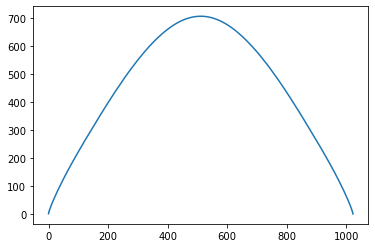

In [38]:
from pylab import *
%matplotlib inline

plot(lngE)

The thermodynamics can be calculated in the following way:

\begin{eqnarray}
Z &=& \sum_E g[E] e^{-E/T}\\
<E^n> &=& \frac{1}{Z} \sum_E g[E] E^n e^{-E/T}\\
c_v &=& \frac{<E^2>-<E>^2}{T^2}\\
F &=& -T \log(Z)\\   
S &=& -\frac{dF}{dT}=log(Z)+\frac{<E>}{T}
\end{eqnarray}
we introduce 
\begin{equation}
Z_0=g[0] e^{-E_0/T}  
\end{equation}    
so that
\begin{eqnarray}    
Z_w &\equiv& \frac{Z_E}{Z_0} = \frac{g[E]}{g[0]} e^{-(E-E_0)/T}\\
Z &=& Z_0 \sum_E Z_w(E) \\
<E^n> &=& \frac{\sum_E Z_w(E) E^n}{\sum_E Z_w(E)}\\
log(Z) &=& log(\sum_E Z_w) +log(Z_0) =  log(\sum_E Z_w)+log(g[0])-E_0/T 
\end{eqnarray}    

In [39]:
(Energies, indE, Emin) = PrepareEnergies(N)

def Thermod(T, lngE, Energies, N):
    Z = 0.
    Ev = 0.  # <E>
    E2v = 0. # <E^2>
    # <E^n> = sum_E e^(-E/T)*g[E] E^n /Z
    # Zw = Z/Z_0
    # <E^n> = Z0/Z sum_E e^(-(E-Emin)/T) g[E]/g[0] E^N
    for i,E in enumerate(Energies):
        # Z += exp(log(g)) * exp(-E/T)
        # Z/Z_0 = w where Z_0 = g[0] exp(-Energies[0]/T)
        w = exp(lngE[i]-lngE[0]-(E-Energies[0])/T) # g(E)/g0 Exp(-(E-E0)/T)
        Z += w
        Ev += w*E
        E2v += w*E**2
    Ev *= 1./Z
    E2v *= 1./Z
    cv = (E2v-Ev**2)/T**2
    # Z_correct = Z * exp(lngE[0]-Energies[0]/T)
    # Entropy = log(Z_correct) + <E>/T = log(Z) + lngE[0]-Energies[0]/T + Ev/T
    Entropy = log(Z)+lngE[0]+Ev/T-Energies[0]/T
    return (Ev/(N**2), cv/(N**2), Entropy/(N**2))

In [41]:
Te = linspace(0.5,4.,300)

Thm=[]
for T in Te:
    Thm.append(Thermod(T, lngE, Energies, N))
Thm = array(Thm)

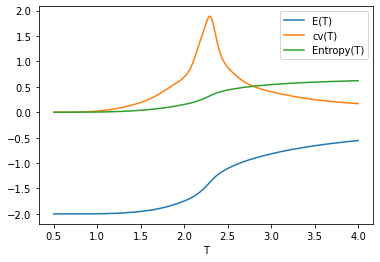

In [42]:
from pylab import *
%matplotlib inline

plot(Te, Thm[:,0], label='E(T)')
plot(Te, Thm[:,1], label='cv(T)')
plot(Te, Thm[:,2], label='Entropy(T)')
xlabel('T')
legend(loc='best')
show()

In [31]:
print('Entropy(T=%5.3f)=%8.6f Entropy(T=%5.3f)=%5.3f * log(2)' % (Te[0],Thm[0,2],Te[-1],Thm[-1,2]/log(2)))

Entropy(T=0.500)=0.000932 Entropy(T=4.000)=0.894 * log(2)


## Homework

* Estimate the error of the density of states $log(g(E))==S(E)$ for 32x32 Ising model. 

To do that, you can use five independent runs of WL agorithm, which will produce $S_i(E)$ for i=1..5. 
In each WL run use $10^9$ Monte Carlo steps. From the series of $S_i(E)$ you can calculate 
\begin{eqnarray}
&& <S(E)> = \frac{1}{n} \sum_{i=1}^n S_i(E) \\
&& \sigma_E = \sqrt{\frac{<S^2(E)>-<S(E)>^2}{n}} = \sqrt{\frac{1}{n^2} \sum_{i=1}^n (S_i(E)-<S(E)>)^2}
\end{eqnarray}

Plot $S_i(E)-<S(E)>$ and $\sigma_E$. 

* According to the publication "Exact Distribution of Energies in the Two-Dimensional Ising Model", PRL 76, 78 (1995), the first 10 values for the density of states in 32x32 Ising model is:
$g_{Exact}=[2,2048,4096,1057792,4218880,371621888,2191790080,100903637504,768629792768,22748079183872]$

Plot $<S(E)>$ and $log(g_{exact})$ for the first 10 coefficients, as well as their difference.

Verify if your estimated $<S(E)>$ is approximately $\sigma_E$ from exact result. To do that, plot $<S(E)>-S_{exact}$ and $\sigma_E$ for the first 10 energies.

* Calculate thermodynamics from your best estimation of $g(E)$.